# Sprint-2. Новые данные

## Задача: Получить рабочую модель для прогона на протезе

###  Содержание <a class="anchor" id=0></a>

- [1. Загрузка библиотек, чтение данных, определение основных функций](#1)
- [2. Песочница с разными моделями](#2)
- [3. Песочница с разными пайплайнами](#3)
- [4. Эмуляция реал-тайм инференса](#4)
- [5. Итоги спринта](#5)


## 1. Загрузка библиотек, чтение данных, определение основных функций <a class="anchor" id=1></a>

[к содержанию](#0)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib widget

free_movements_1 = pd.read_csv('free_movements.csv', index_col=0)
free_movements_2 = pd.read_csv('free_movements_2.csv', index_col=0)

OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
INDEX = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'RUN time'] # для удобства вывода отчетов
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements_1.shape[-1]

gestures_train_1 = pd.read_csv('gestures_train.csv', index_col=0)
gestures_test_1 = pd.read_csv('gestures_test.csv', index_col=0)
gestures_protocol_1 = pd.read_csv('gestures_protocol.csv')

gestures_train_2 = pd.read_csv('gestures_train_2.csv', index_col=0)
gestures_test_2 = pd.read_csv('gestures_test_2.csv', index_col=0)
gestures_protocol_2 = pd.read_csv('gestures_protocol_2.csv')

gestures_train_ext_1 = pd.merge(
    gestures_train_1,
    gestures_protocol_1,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext_1 = pd.merge(
    gestures_test_1,
    gestures_protocol_1,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_train_ext_2 = pd.merge(
    gestures_train_2,
    gestures_protocol_2,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext_2 = pd.merge(
    gestures_test_2,
    gestures_protocol_2,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

Забегая вперёд, при обработке данных и подборе модели, будем пользоваться функциями которые понадобятся в эмуляции `inferenc'а` в `real-time`.

In [2]:
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse


def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def preprocessing_static(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y, axis=1)

def inference(x):
    """_получение предсказаний модели_

    """
    y = np.rint(model.predict(x))

    return y

def fast_post(array, step=10):
    
    return np.round(array / step, 0).astype(int) * step


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

## 2. Песочница с разными моделями <a class="anchor" id=2></a>

[к содержанию](#0)

Пробовать модели будем на "чистых" данных

In [5]:
X_1 = gestures_train_1[OMG_CH].values
X_test_1 = gestures_test_1[OMG_CH].values
y_1 = gestures_train_1[GLOVE_CH].values
y_test_1 = gestures_test_1[GLOVE_CH].values
print(X_1.shape, y_1.shape, X_test_1.shape, y_test_1.shape)

X_2 = gestures_train_2[OMG_CH].values
X_test_2 = gestures_test_2[OMG_CH].values
y_2 = gestures_train_2[GLOVE_CH].values
y_test_2 = gestures_test_2[GLOVE_CH].values
X_2.shape, y_2.shape, X_test_2.shape, y_test_2.shape

X = X_1
y = y_1
X_test = X_test_1
y_test = y_test_1

(21320, 50) (21320, 6) (5330, 50) (5330, 6)


In [147]:
X_test_1 == X_test_2

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [139]:
def tester(model, X=X_1, y=y_1, X_test=X_test_1, y_test=y_test_1):
    model.fit(X, y)
    y_pred = model.predict(X_test)
    return MSE(y_test, y_pred)

In [141]:
print(tester(LinearRegression()))
tester(LinearRegression()).sum()

0   104.758887
1    55.782135
2    44.351714
3   117.644508
4    74.007256
5     0.000000
dtype: float64


396.54449947455083

Отправной точкой примем линейную регрессию на чистых данных, без пред и пост обработки.

In [11]:
# время выполнения ~ 6.5s
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars

lr_1 = LinearRegression().fit(X_1, y_1)

start_time = time.time()

y_pred_1 = lr_1.predict(X_1)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_1 = lr_1.predict(X_test_1)

LR_1 = pd.DataFrame({'INDEX':INDEX, 'LinearRegression':MSE(y_test_1, y_test_pred_1).append(run_time)}).set_index('INDEX')


start_time = time.time()

y_pred_2 = lr_1.predict(X_2)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_2 = lr_1.predict(X_test_2)

LR_2 = pd.DataFrame({'INDEX':INDEX, 'LinearRegression':MSE(y_test_2, y_test_pred_2).append(run_time)}).set_index('INDEX')



en_1 = ElasticNet().fit(X_1, y_1)

start_time = time.time()

y_pred_1 = en_1.predict(X_1)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_1 = en_1.predict(X_test_1)

EN_1 = pd.DataFrame({'INDEX':INDEX, 'ElasticNet':MSE(y_test_1, y_test_pred_1).append(run_time)}).set_index('INDEX')


start_time = time.time()

y_pred_2 = en_1.predict(X_2)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_2 = en_1.predict(X_test_2)

EN_2 = pd.DataFrame({'INDEX':INDEX, 'ElasticNet':MSE(y_test_2, y_test_pred_2).append(run_time)}).set_index('INDEX')


ll_1 = LassoLars().fit(X_1, y_1)

start_time = time.time()

y_pred_1 = ll_1.predict(X_1)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_1 = ll_1.predict(X_test_1)

LL_1 = pd.DataFrame({'INDEX':INDEX, 'LassoLars':MSE(y_test_1, y_test_pred_1).append(run_time)}).set_index('INDEX')


start_time = time.time()

y_pred_2 = ll_1.predict(X_2)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred_2 = ll_1.predict(X_test_2)

LL_2 = pd.DataFrame({'INDEX':INDEX, 'LassoLars':MSE(y_test_2, y_test_pred_2).append(run_time)}).set_index('INDEX')



print('Итог по линейкам "из коробки":')
Linear_df = pd.concat([LR_1, EN_1, LL_1], axis=1)
Linear_df

Итог по линейкам "из коробки":


,LinearRegression,ElasticNet,LassoLars
INDEX,,,
ENC0,104.758887,103.509828,103.813914
ENC1,55.782135,55.924965,56.606248
ENC2,44.351714,44.358204,44.611839
ENC3,117.644508,117.724573,118.573314
ENC4,74.007256,73.511306,73.636358
ENC5,0.000000,0.000000,0.000000
RUN time,0.004989,0.006980,0.005978


In [6]:
# время выполнения ~ 16.5s

pd.options.display.float_format = '{:.6f}'.format #для отображения "обычных" float

import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

xgbr = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=mse)
xgbr.fit(X, y)

start_time = time.time()

y_pred = xgbr.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = xgbr.predict(X_test)

XGB = pd.DataFrame({'INDEX':INDEX, 'XGBRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')


lgbr = MultiOutputRegressor(lgb.LGBMRegressor())
lgbr.fit(X, y)

start_time = time.time()

y_pred = lgbr.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = lgbr.predict(X_test)

LGB = pd.DataFrame({'INDEX':INDEX, 'LGBMRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')

print('Итог по бустерам "из коробки":')
Booster_df = pd.concat([XGB, LGB], axis=1)
Booster_df

Итог по бустерам "из коробки":


,XGBRegressor,LGBMRegressor
INDEX,,
ENC0,134.066844,140.924633
ENC1,70.753121,95.102997
ENC2,60.404317,65.039729
ENC3,65.086342,82.861908
ENC4,50.467767,61.008120
ENC5,0.000000,0.000000
RUN time,0.048870,0.181515


И мой любимый стек

In [7]:
# время выполнения ~ 7s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model = MultiOutputRegressor(VotingRegressor(estimators=estimators))

model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

VR = pd.DataFrame({'INDEX':INDEX, 'VotingRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')

In [12]:
print('Итог по базовым моделям:')
Models_df = pd.concat([Linear_df, Booster_df, VR], axis=1)
Models_df

Итог по базовым моделям:


,LinearRegression,ElasticNet,LassoLars,XGBRegressor,LGBMRegressor,VotingRegressor
INDEX,,,,,,
ENC0,104.758887,103.509828,103.813914,134.066844,140.924633,116.665205
ENC1,55.782135,55.924965,56.606248,70.753121,95.102997,48.154441
ENC2,44.351714,44.358204,44.611839,60.404317,65.039729,59.936817
ENC3,117.644508,117.724573,118.573314,65.086342,82.861908,100.544917
ENC4,74.007256,73.511306,73.636358,50.467767,61.008120,51.523898
ENC5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RUN time,0.004989,0.006980,0.005978,0.048870,0.181515,0.076792


Определим тройку финалистов

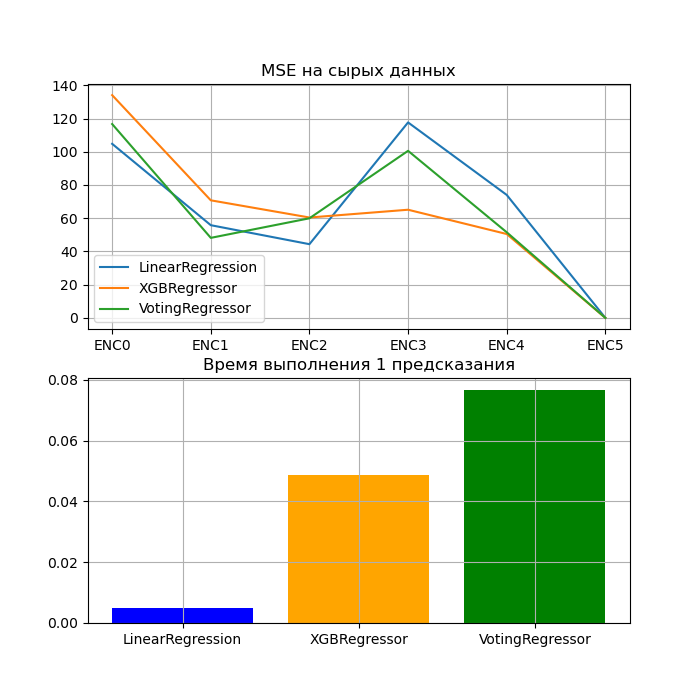

In [13]:

fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ax[0].set_title('MSE на сырых данных')
ax[0].plot(Models_df.drop(columns=['ElasticNet', 'LassoLars', 'LGBMRegressor']).drop('RUN time', axis=0),
           label=['LinearRegression','XGBRegressor','VotingRegressor'])
ax[0].legend()
ax[0].grid()
ax[1].set_title('Время выполнения 1 предсказания')
ax[1].bar(x=Models_df.drop(columns=['ElasticNet', 'LassoLars', 'LGBMRegressor']).iloc[-1].index,
          height=Models_df.drop(columns=['ElasticNet', 'LassoLars', 'LGBMRegressor']).iloc[-1].values,
          color = ['blue', 'orange', 'green'])
ax[1].grid()

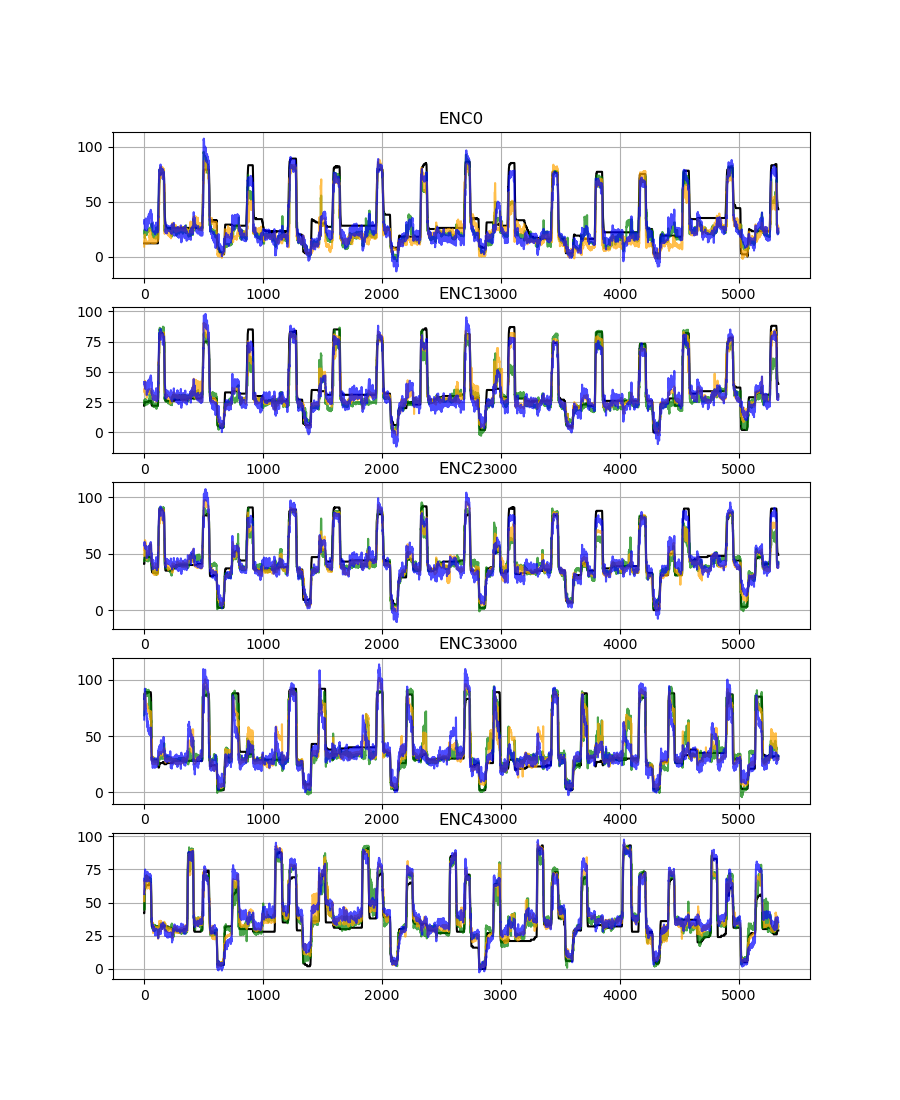

In [20]:

fig, ax = plt.subplots(5, 1, figsize=(9, 11))

ax[0].set_title('ENC0')
ax[0].plot(y_test[:,0], c='k')
ax[0].plot(model.predict(X_test)[:,0], alpha=0.7, c='g')
ax[0].plot(xgbr.predict(X_test)[:,0], alpha=0.7, c='orange')
ax[0].plot(lr.predict(X_test)[:,0], alpha=0.7, c='b')
ax[0].grid()

ax[1].set_title('ENC1')
ax[1].plot(y_test[:,1], c='k')
ax[1].plot(xgbr.predict(X_test)[:,1], alpha=0.7, c='g')
ax[1].plot(model.predict(X_test)[:,1], alpha=0.7, c='orange')
ax[1].plot(lr.predict(X_test)[:,1], alpha=0.7, c='b')
ax[1].grid()

ax[2].set_title('ENC2')
ax[2].plot(y_test[:,2], c='k')
ax[2].plot(xgbr.predict(X_test)[:,2], alpha=0.7, c='g')
ax[2].plot(model.predict(X_test)[:,2], alpha=0.7, c='orange')
ax[2].plot(lr.predict(X_test)[:,2], alpha=0.7, c='b')
ax[2].grid()

ax[3].set_title('ENC3')
ax[3].plot(y_test[:,3], c='k')
ax[3].plot(xgbr.predict(X_test)[:,3], alpha=0.7, c='g')
ax[3].plot(model.predict(X_test)[:,3], alpha=0.7, c='orange')
ax[3].plot(lr.predict(X_test)[:,3], alpha=0.7, c='b')
ax[3].grid()

ax[4].set_title('ENC4')
ax[4].plot(y_test[:,4], c='k')
ax[4].plot(xgbr.predict(X_test)[:,4], alpha=0.7, c='g')
ax[4].plot(model.predict(X_test)[:,4], alpha=0.7, c='orange')
ax[4].plot(lr.predict(X_test)[:,4], alpha=0.7, c='b')
ax[4].grid()

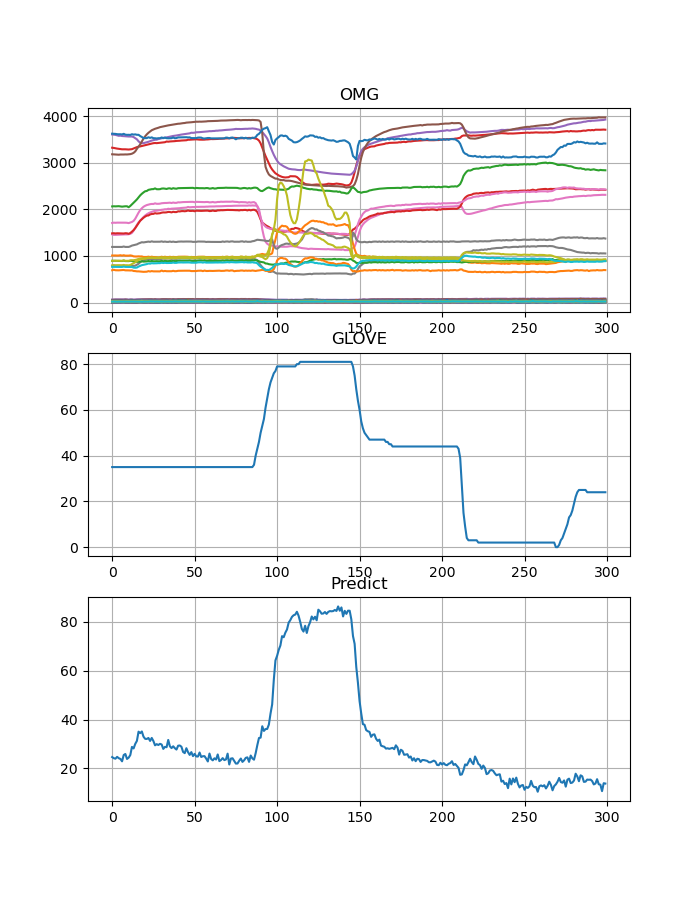

In [51]:
fig, ax = plt.subplots(3, 1, figsize=(7, 9))

ax[0].set_title('OMG')
ax[0].plot(X_test[4800:5100])
#ax[0].legend()
ax[0].grid()
ax[1].set_title('GLOVE')
ax[1].plot(y_test[4800:5100][:,0])
ax[1].grid()
ax[2].set_title('Predict')
ax[2].plot(ll.predict(X_test)[4800:5100][:,0])
ax[2].grid()

In [79]:
def fast_post(array):
    
    return np.round(array / 100, 0).astype(int) * 100

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 100, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0, 100, ...,   0,   0,   0],
       [  0,   0, 100, ...,   0,   0,   0],
       [  0,   0, 100, ...,   0,   0,   0]])

In [11]:
# время выполнения ~ 4s
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

model = MultiOutputRegressor(lgb.LGBMRegressor())
model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

LGB = pd.DataFrame({'INDEX':INDEX, 'LGBMRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('XGBRegressor RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

XGBRegressor RAW


,train,test
GLOVE_CH,,
ENC0,6.246136,140.924633
ENC1,3.135605,95.102997
ENC2,3.361059,65.039729
ENC3,5.709942,82.861908
ENC4,4.365872,61.008120
ENC5,0.000000,0.000000


In [12]:
print('Итог по бустерам "из коробки":')
Booster_df = pd.concat([GBR, XGB, LGB], axis=1)
Booster_df

Итог по бустерам "из коробки":


,GradientBoostingRegressor,XGBRegressor,LGBMRegressor
INDEX,,,
ENC0,133.973763,1.340668e+02,140.924633
ENC1,89.217912,7.075312e+01,95.102997
ENC2,60.266299,6.040432e+01,65.039729
ENC3,65.546117,6.508634e+01,82.861908
ENC4,65.709790,5.046777e+01,61.008120
ENC5,0.000000,2.625986e-32,0.000000
RUN time,0.146006,6.567430e-02,0.158714


***
Теперь будем пробовать деревянные регрессоры

In [12]:
# время выполнения ~ 2min
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor().fit(X,y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

RFR = pd.DataFrame({'INDEX':INDEX, 'RandomForestRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('RandomForestRegressor RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

RandomForestRegressor RAW


,train,test
GLOVE_CH,,
ENC0,1.065427,37.411415
ENC1,0.892260,35.626683
ENC2,1.036877,29.124771
ENC3,3.827574,208.845574
ENC4,5.592010,406.478035
ENC5,0.000000,0.000000


In [13]:
# время выполнения ~ 40s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import BaggingRegressor

model = MultiOutputRegressor(BaggingRegressor())
model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_train_pred = model.predict(X_test)

BR = pd.DataFrame({'INDEX':INDEX, 'BaggingRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('BaggingRegressor RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

BaggingRegressor RAW


,train,test
GLOVE_CH,,
ENC0,1.830091,140.924633
ENC1,1.163250,95.102997
ENC2,0.777887,65.039729
ENC3,1.517415,82.861908
ENC4,1.038609,61.008120
ENC5,0.000000,0.000000


In [14]:
# время выполнения ~ 30s
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_train_pred = model.predict(X_test)

ETR = pd.DataFrame({'INDEX':INDEX, 'ExtraTreesRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('ExtraTreesRegressor RAW')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

ExtraTreesRegressor RAW


,train,test
GLOVE_CH,,
ENC0,0.0,140.924633
ENC1,0.0,95.102997
ENC2,0.0,65.039729
ENC3,0.0,82.861908
ENC4,0.0,61.008120
ENC5,0.0,0.000000


In [15]:
print('Итог по деревьям "из коробки":')
Tree_df = pd.concat([BR, ETR], axis=1)
Tree_df

Итог по деревьям "из коробки":


,BaggingRegressor,ExtraTreesRegressor
INDEX,,
ENC0,140.924633,140.924633
ENC1,95.102997,95.102997
ENC2,65.039729,65.039729
ENC3,82.861908,82.861908
ENC4,61.008120,61.008120
ENC5,0.000000,0.000000
RUN time,0.281978,0.281209


Попробуем стакнуть несколько линеек

In [16]:
# время выполнения ~ 35s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model = MultiOutputRegressor(StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
))

model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

ST = pd.DataFrame({'INDEX':INDEX, 'StackingRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('StackingRegressor')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

StackingRegressor


,train,test
GLOVE_CH,,
ENC0,47.460519,109.315226
ENC1,29.909474,52.471697
ENC2,16.372955,55.039279
ENC3,23.390420,107.396155
ENC4,33.355026,60.991988
ENC5,0.000000,0.000000


In [17]:
# время выполнения ~ 7s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model = MultiOutputRegressor(VotingRegressor(estimators=estimators))

model.fit(X, y)

start_time = time.time()

y_pred = model.predict(X)

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = model.predict(X_test)

VR = pd.DataFrame({'INDEX':INDEX, 'VotingRegressor':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('VotingRegressor')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

VotingRegressor


,train,test
GLOVE_CH,,
ENC0,22.764511,97.424652
ENC1,15.357349,46.651458
ENC2,13.545640,52.129604
ENC3,29.244164,100.800241
ENC4,16.459708,49.414272
ENC5,0.000000,0.000000


In [18]:
print('Итог по базовым стекам:')
Stacks_df = pd.concat([ST, VR], axis=1)
Stacks_df

Итог по базовым стекам:


,StackingRegressor,VotingRegressor
INDEX,,
ENC0,109.315226,97.424652
ENC1,52.471697,46.651458
ENC2,55.039279,52.129604
ENC3,107.396155,100.800241
ENC4,60.991988,49.414272
ENC5,0.000000,0.000000
RUN time,0.051228,0.053351


In [19]:
print('Итог по базовым моделям "из коробки":')
Models_df = pd.concat([Linear_df, Booster_df, Tree_df, Stacks_df], axis=1)
Models_df

Итог по базовым моделям "из коробки":


,LinearRegression,ElasticNet,LassoLars,GradientBoostingRegressor,XGBRegressor,LGBMRegressor,BaggingRegressor,ExtraTreesRegressor,StackingRegressor,VotingRegressor
INDEX,,,,,,,,,,
ENC0,104.758887,103.509828,103.813914,133.973763,1.340668e+02,140.924633,140.924633,140.924633,109.315226,97.424652
ENC1,55.782135,55.924965,56.606248,89.217912,7.075312e+01,95.102997,95.102997,95.102997,52.471697,46.651458
ENC2,44.351714,44.358204,44.611839,60.266299,6.040432e+01,65.039729,65.039729,65.039729,55.039279,52.129604
ENC3,117.644508,117.724573,118.573314,65.546117,6.508634e+01,82.861908,82.861908,82.861908,107.396155,100.800241
ENC4,74.007256,73.511306,73.636358,65.709790,5.046777e+01,61.008120,61.008120,61.008120,60.991988,49.414272
ENC5,0.000000,0.000000,0.000000,0.000000,2.625986e-32,0.000000,0.000000,0.000000,0.000000,0.000000
RUN time,0.008777,0.017687,0.008456,0.146006,6.567430e-02,0.158714,0.281978,0.281209,0.051228,0.053351


***
## Подведём промежуточныйе итоги:
* Линейки **очень** быстрые, но обладают низкой точностью

* Бустеры из коробки показывают **приличные отправные метрики**, но оставляют совсем мало времени на пред и пост обработку сигналов

* "Деревья" медленные и с так-себе метриками

Имеем проблему знакомую любым игрокам в РПГ, кого будем качать? Сильного дебила или умного слабака?
На данном этапе, я бы продолжил вести в параллель 2 сценария:

1. Стек из линейки и дерева собранный на **VotingRegressor** с кучей пред и пост обработки

2. **XGBRegressor** с оптимизацией параметров и минимумом пост обработки

## 3. Песочница с разными пайплайнами <a class="anchor" id=3></a>

[к содержанию](#0)

К этому этапу **не сработало**:
1. Стандартизация и нормализация (`MinMaxScaler`, `RobustScaler`, `StandardScaler`)

2. Полиномиальные фичи и трансформеры (`PolynomialFeatures`, `PowerTransformer`, `QuantileTransformer`)

Хотелось бы в предпроцессинге реализовать "умное сглаживание датчиков" на основе 2-3 изменений (нужно буферное окно)

Попробуем с текущим предпроцессингом: добавление в предикты разницы в показаниях датчиков за 1 шаг.

И постпроцессингом: помещаем все предсказания в диапазон от 0 до 100 и дискретизируем предсказания на 11 диапазонов (по верхам шаг можно уменьшить)

In [20]:
# время выполнения ~ 27s
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model = MultiOutputRegressor(VotingRegressor(estimators=estimators))

X = preprocessing_static(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing_static(X_test, np.vstack((X_test[1:], X_test[:1])))

model.fit(X, y)

start_time = time.time()

y_pred = inference(X)
y_pred = postprocessing(y_pred)
y_pred = commands(y_pred, np.vstack((y_pred[1:], y_pred[:1])))

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = inference(X_test)
y_test_pred = postprocessing(y_test_pred)
y_test_pred = commands(y_test_pred, np.vstack((y_test_pred[1:], y_test_pred[:1])))


VR_post = pd.DataFrame({'INDEX':INDEX, 'VR pred&post':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('VR pred&post')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

VR pred&post


,train,test
GLOVE_CH,,
ENC0,49.433771,170.161820
ENC1,42.211515,89.256473
ENC2,41.568269,89.172983
ENC3,54.855464,98.255629
ENC4,41.921811,41.697092
ENC5,0.000000,0.000000


In [21]:
# время выполнения ~ 4s
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb


X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values


model = MultiOutputRegressor(lgb.LGBMRegressor())

X = preprocessing_static(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing_static(X_test, np.vstack((X_test[1:], X_test[:1])))

model.fit(X, y)

start_time = time.time()

y_pred = inference(X)
y_pred = postprocessing(y_pred)
y_pred = commands(y_pred, np.vstack((y_pred[1:], y_pred[:1])))

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = inference(X_test)
y_test_pred = postprocessing(y_test_pred)
y_test_pred = commands(y_test_pred, np.vstack((y_test_pred[1:], y_test_pred[:1])))

LGB_post = pd.DataFrame({'INDEX':INDEX, 'LGBMR pred&post':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('LGBMR pred&post')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

LGBMR pred&post


,train,test
GLOVE_CH,,
ENC0,33.193621,235.185741
ENC1,30.004784,160.068856
ENC2,28.655629,120.219887
ENC3,30.013297,80.573171
ENC4,27.681543,53.816698
ENC5,0.000000,0.000000


Подберём гиперпараметры `Optun'ой`

In [22]:
import optuna
def optuna_lgb(trial):
  
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 10, 150, 1)
    max_depth = trial.suggest_int('max_depth', 15, 100, 1)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 200, 1)
    
    
    model_op = MultiOutputRegressor(lgb.LGBMRegressor(
                                        metric = 'l2', 
                                        random_state = 32,
                                        learning_rate = learning_rate,
                                        num_leaves = num_leaves,
                                        max_depth = max_depth,
                                        min_data_in_leaf = min_data_in_leaf
                                    ))

    model_op.fit(X, y)
    score = MSE(y_test, model_op.predict(X_test))[4]

    return score

In [23]:
study = optuna.create_study(study_name="LGBMR pred&post", direction="minimize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lgb, n_trials=5, show_progress_bar=True)

[I 2023-05-10 20:30:09,120] A new study created in memory with name: LGBMR pred&post


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[I 2023-05-10 20:30:17,917] Trial 0 finished with value: 293.1860773274446 and parameters: {'learning_rate': 0.1250865784659727, 'num_leaves': 116, 'max_depth': 47, 'min_data_in_leaf': 114}. Best is trial 0 with value: 293.1860773274446.
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[I 2023-05-10 20:30:25,822] Trial 1 finished with value: 381.8502162125566 and parameters: {'learning_rate': 0.2200638663289082, 'num_leaves': 130, 'max_depth': 56, 'min_data_in_leaf': 49}. Best is trial 0 with value: 293.1860773274446.
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[I 2023-05-10 20:30:33,472] Trial 2 finished with value: 342.92129415301764 and parameters: {'learning_rate': 0.16098111878767712, 'num_leaves': 94, 'max_d

In [38]:
#best_params = study.best_params
#best_params

{'learning_rate': 0.2572978923100677,
 'num_leaves': 32,
 'max_depth': 35,
 'min_data_in_leaf': 108}

In [24]:
# время выполнения ~ 5s
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values

model = MultiOutputRegressor(lgb.LGBMRegressor( 
                                learning_rate = 0.25,
                                num_leaves = 30,
                                max_depth = 30,
                                min_data_in_leaf = 100))

X = preprocessing_static(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing_static(X_test, np.vstack((X_test[1:], X_test[:1])))

model.fit(X, y)

start_time = time.time()

y_pred = inference(X)
y_pred = postprocessing(y_pred)
y_pred = commands(y_pred, np.vstack((y_pred[1:], y_pred[:1])))

run_time = pd.Series((time.time() - start_time))
run_time.index = ['run_time']

y_test_pred = inference(X_test)
y_test_pred = postprocessing(y_test_pred)
y_test_pred = commands(y_test_pred, np.vstack((y_test_pred[1:], y_test_pred[:1])))

LGB_post = pd.DataFrame({'INDEX':INDEX, 'LGBMR pred&post':MSE(y_test, y_test_pred).append(run_time)}).set_index('INDEX')
print('LGBMR pred&post')
pd.DataFrame({'GLOVE_CH':GLOVE_CH, 'train':MSE(y, y_pred), 'test':MSE(y_test, y_test_pred)}).set_index('GLOVE_CH')

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
LGBMR pred&post


,train,test
GLOVE_CH,,
ENC0,28.947365,27.794564
ENC1,28.440628,27.981085
ENC2,20.972010,27.189398
ENC3,23.978973,161.879530
ENC4,30.371805,268.254224
ENC5,0.000000,0.000000


На этом месте хорошо бы прикрутить сглаживатели и фильты на показания датчиков, а может и не хорошо, ктож знает?..
Я на всякий случай добавлю к предиктам изменения в показаниях датчиков за последний шаг.

In [25]:
print('Итог по базовым моделям "из коробки":')
Final_df = pd.concat([VR_post, LGB_post], axis=1)
Final_df

Итог по базовым моделям "из коробки":


,VR pred&post,LGBMR pred&post
INDEX,,
ENC0,34.844944,27.794564
ENC1,38.229003,27.981085
ENC2,40.850943,27.189398
ENC3,180.362023,161.879530
ENC4,357.250000,268.254224
ENC5,0.000000,0.000000
RUN time,0.125765,0.269250


***
## Подведём промежуточныйе итоги:

* Стек линеек **ощутимо быстрее**, но нуждается в дополнительной обработке, **больше авторегрессий богу авторегрессий**

* 10~15ms уходит на пред и постпроцессинг, опчти половина отведённого времени, а выхлоп от них минимален.

## 4. Эмуляция реал-тайм инференса <a class="anchor" id=4></a>

[к содержанию](#0)

In [26]:
import time
import serial
from IPython.display import clear_output


In [27]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

In [28]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoLars
from sklearn.ensemble import VotingRegressor

X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values

estimators = [
    ('dt', DecisionTreeRegressor()),
    ('ll', LassoLars())
]
model_vr = MultiOutputRegressor(VotingRegressor(estimators=estimators))

X = preprocessing_static(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing_static(X_test, np.vstack((X_test[1:], X_test[:1])))

model_vr.fit(X, y)

MultiOutputRegressor(estimator=VotingRegressor(estimators=[('dt',
                                                            DecisionTreeRegressor()),
                                                           ('ll',
                                                            LassoLars())]))

In [29]:
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb


X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values


model_lgbm = MultiOutputRegressor(lgb.LGBMRegressor())

X = preprocessing_static(X, np.vstack((X[1:], X[:1])))
X_test = preprocessing_static(X_test, np.vstack((X_test[1:], X_test[:1])))

model_lgbm.fit(X, y)

MultiOutputRegressor(estimator=LGBMRegressor())

In [30]:
from sklearn.metrics import mean_squared_error as mse

def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def preprocessing(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y)

def inference(x):
    """_получение предсказаний модели_
        np.rint - для дотягивания float'ов до ближайших int'ов
    """
    return model_vr.predict(x.reshape(1,-1))[0]


def postprocessing(array):
    """_дискретизация предсказаний модели
        используется в качестве постпроцессинга
        сюда желательно добавить сглаживатель пиков_
    
    """
    array[array < 10] = 0
    array[(array > 10) & (array <20)] = 10
    array[(array > 20) & (array <30)] = 20
    array[(array > 30) & (array <40)] = 30
    array[(array > 40) & (array <50)] = 40
    array[(array > 50) & (array <60)] = 50
    array[(array > 60) & (array <70)] = 60
    array[(array > 70) & (array <80)] = 70
    array[(array > 80) & (array <90)] = 80
    array[(array > 90) & (array <95)] = 90
    array[array > 95] = 100
    return array


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

In [31]:
df_sim = gestures_test.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(8168, 65)


In [32]:
TIMEOUT = 0.033
DEBUG = True

ts_list = [] 
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
omg_previous = None # эту переменную добавил для "супер умного" препроцессинга, в иделае тут всякие сглаживатели бы накрутить


y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, omg_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
  
    # [/Data logging]

    y_previous = y_postprocessed # для сглаживания 
    omg_previous = omg_sample # просто чтобы была
    
    ts_list.append(ts_diff) # проверю времена выполнения
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 1000, SYNC: 539, TS: 7856565
[ 0. 10.  0. 20. 10.  0.]


In [33]:
#y_dct['y_commands'] = y_dct['y_commands'][1:]

for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8168, 50)
enc_sample.shape = (8168, 6)
sample_preprocessed.shape = (8168, 100)
y_predicted.shape = (8168, 6)
y_postprocessed.shape = (8168, 6)
y_commands.shape = (8168, 6)


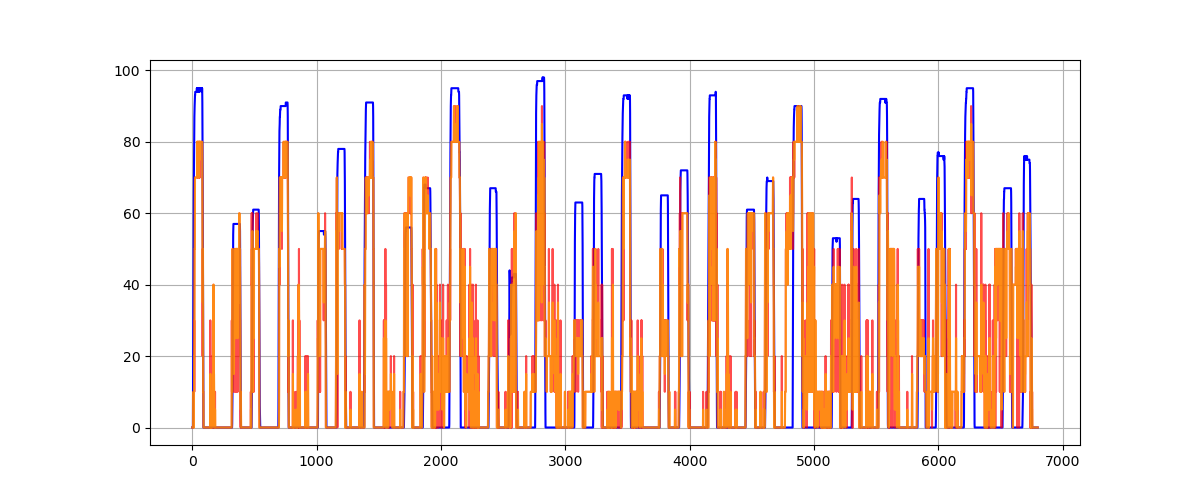

In [35]:
plt.clf()
fig = plt.figure(figsize=(12, 5))

plt.plot(y_dct['enc_sample'][:,4][:6800], color='blue')
plt.plot(y_dct['y_postprocessed'][:,4][:6800], color='red', alpha=0.7)
plt.plot(y_dct['y_commands'][:,4][:6800], color='orange', alpha=0.7)
plt.grid()


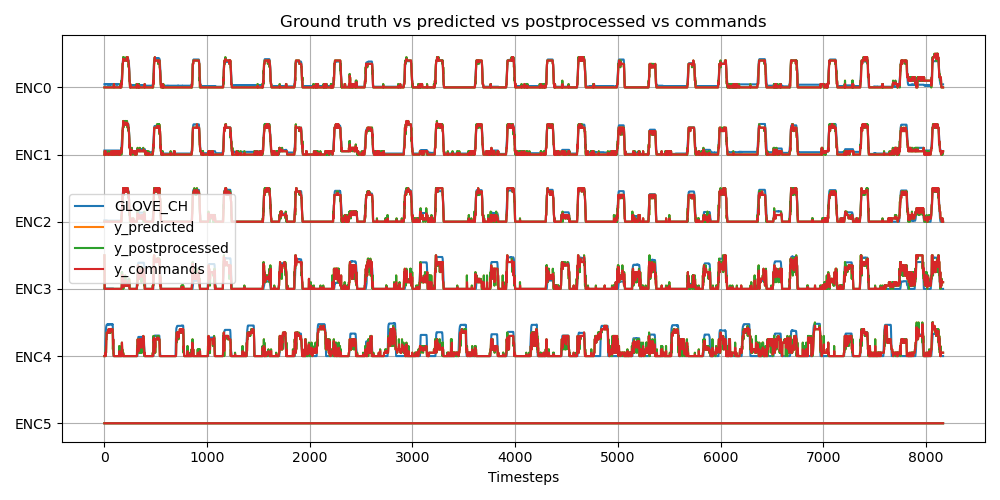

In [36]:
plt.clf()
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

***

In [37]:
from sklearn.metrics import mean_squared_error as mse

def MSE(y, y_pred):
    """_получение среднеквадратичной ошибки для каждого таргета_

    """
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def preprocessing(x, prev):
    """_добавление изменения показаний датчиков за 1 шаг
        используется в качестве препроцессинга_
    """
    if prev is None:
        y = x
    else:
        y = x - prev 
    return np.append(x, y)

def inference(x):
    """_получение предсказаний модели_
        np.rint - для дотягивания float'ов до ближайших int'ов
    """
    return model_lgbm.predict(x.reshape(1,-1))[0]


def postprocessing(array):
    """_дискретизация предсказаний модели
        используется в качестве постпроцессинга
        сюда желательно добавить сглаживатель пиков_
    
    """
    array[array < 10] = 0
    array[(array > 10) & (array <20)] = 10
    array[(array > 20) & (array <30)] = 20
    array[(array > 30) & (array <40)] = 30
    array[(array > 40) & (array <50)] = 40
    array[(array > 50) & (array <60)] = 50
    array[(array > 60) & (array <70)] = 60
    array[(array > 70) & (array <80)] = 70
    array[(array > 80) & (array <90)] = 80
    array[(array > 90) & (array <95)] = 90
    array[array > 95] = 100
    return array


def commands(x, prev):
    """_преобразование таргетов в команды
        используется в качестве финального "коэффициента подгона"_
        пока лучшего сглаживателя нет времено использую фильтр Хольта
    """
    if prev is None:
        y = x
    else:
        y = x*0.5 + prev*0.5
    return y

In [38]:
df_sim = gestures_test.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(8168, 65)


In [43]:
TIMEOUT = 0.33
DEBUG = True

ts_list = [] 
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
omg_previous = None # эту переменную добавил для "супер умного" препроцессинга, в иделае тут всякие сглаживатели бы накрутить


y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, omg_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
  
    # [/Data logging]

    y_previous = y_postprocessed # для сглаживания 
    omg_previous = omg_sample # просто чтобы была
    
    ts_list.append(ts_diff) # проверю времена выполнения
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 


SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 1000, SYNC: 539, TS: 7856565
[ 5. 10. 10. 20. 45.  0.]


In [44]:
#y_dct['y_commands'] = y_dct['y_commands'][1:]

for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8168, 50)
enc_sample.shape = (8168, 6)
sample_preprocessed.shape = (8168, 100)
y_predicted.shape = (8168, 6)
y_postprocessed.shape = (8168, 6)
y_commands.shape = (8168, 6)


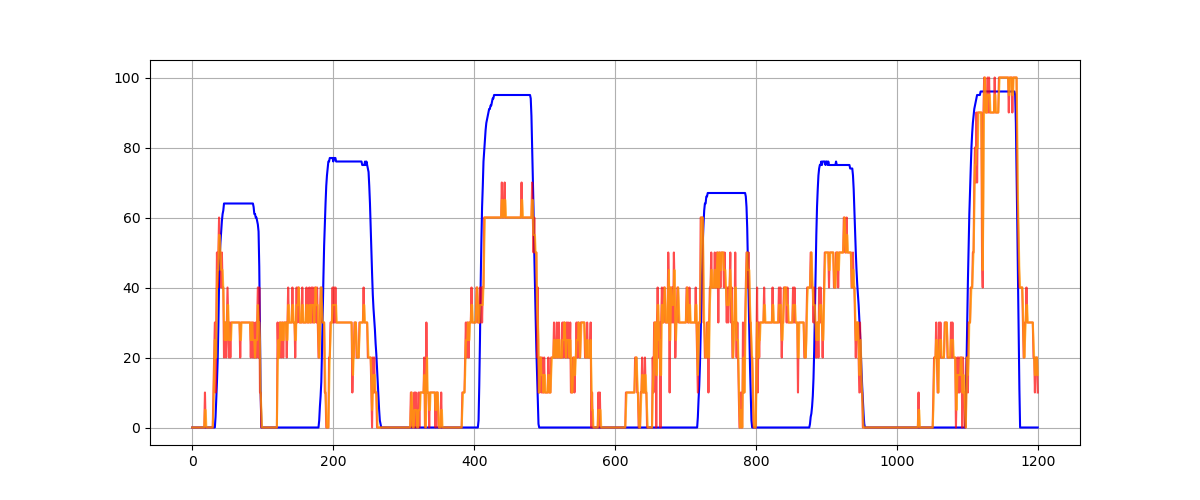

In [45]:
plt.clf()
fig = plt.figure(figsize=(12, 5))

plt.plot(y_dct['enc_sample'][:,4][5800:7000], color='blue')
plt.plot(y_dct['y_postprocessed'][:,4][5800:7000], color='red', alpha=0.7)
plt.plot(y_dct['y_commands'][:,4][5800:7000], color='orange', alpha=0.7)
plt.grid()

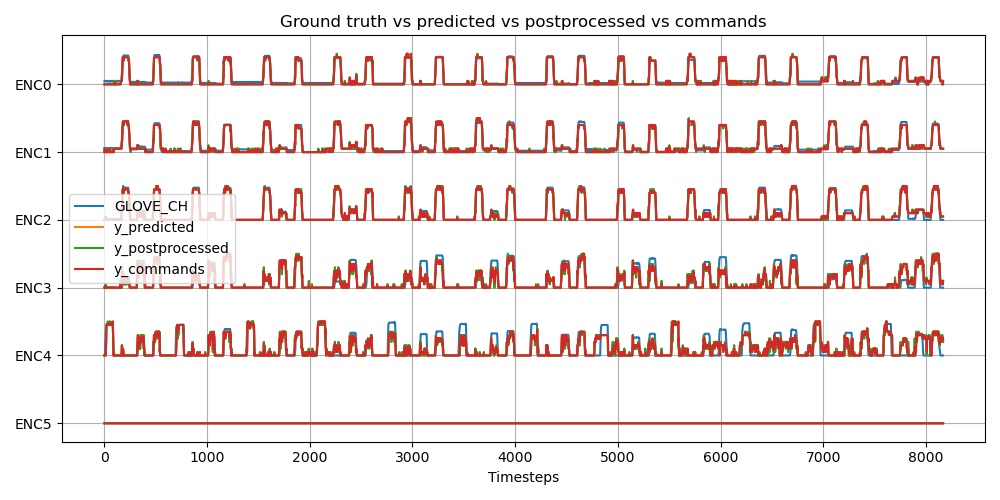

In [46]:
plt.clf()
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

## 5. Итоги спринта <a class="anchor" id=5></a>

[к содержанию](#0)

Я **очень** надеюсь, что правильно определил задачу первого спринта, как "общее знакомство с данными", потому, что на тестовых данных, модельки худо - бедно, но что-то показать могут, а вот со свободными жестами беда.. 

Но всё же:

* Стек из линейки и дерева вполне способен решить поставленную задачу.

* А градиентный бустинг буд-то бы созда для её решения.

* Но решения можно достигнуть при условии доработки **пред и постпроцессинга**, возможные пути:

* * Сглаживание показаний датчиков (где-то тут можно попробовать приложить авторегрессию)

* * Отсекание неинформативных датчиков (как определить какие датчики и **когда** являются "неинформативными" - отдельный вопрос)

* * Нужно больше узнать хардовую часть датчиков и процесса сьъёма показаний (хочется большей универсальности показаний, чтобы не было сильной разницы от "монтажа" и от "пилота", на данном этапе интуитивно хочется брать не сами показания а изменения в абсолютных значениях)

* * На постпроцессинге нужно срезать пики и убирать биения (сюда тоже можно приложить авторегрессию)


